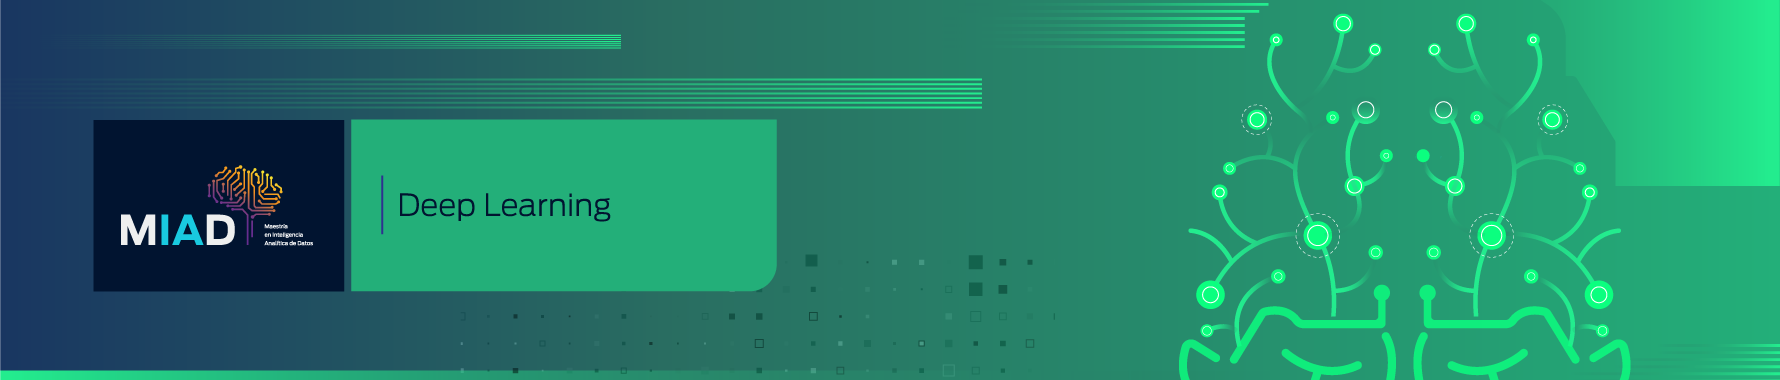

# Implementación y entrenamiento de redes neuronales

## Redes neuronales: Calibración de una red neuronal de una capa

### Propósito 

En esta actividad pondrán en práctica la calibración de los parámetros de una red neuronal utilizando el método de gradiente descendiente. Para ello, se utilizarán procedimientos detallados sin funciones de librerías ya existentes, de tal manera que se pueda observar paso a paso la ejecución del algoritmo.

Siguiendo los pasos de este notebook construirán una red neuronal que tendrá la siguiente estructura:

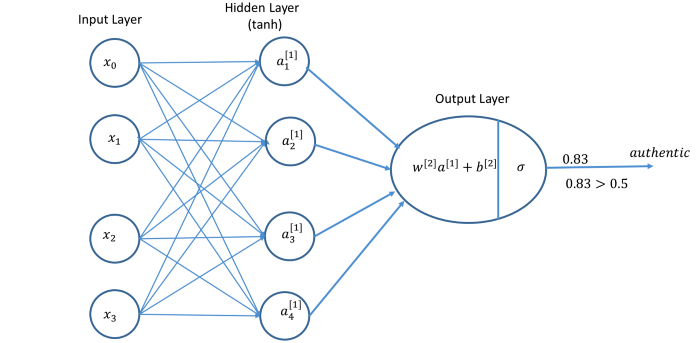
Figura 1. Estructura de red neuronal de una capa oculta. 

### Instrucciones generales

1. Para realizar la actividad solo siga las indicaciones asociadas a cada celda del notebook. Sin embargo, siéntase libre de modificar el archivo editando las celdas, lo que le permitirá afianzar su comprensión sobre las distintas funcionalidades de código.  
2. Recuerde que para esta actividad NO necesita realizar ningún tipo de entrega.


### Librerías a importar

A continuación se muestran los comandos a ejecutar para poder implementar los procedimientos de este notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Pasos para implementar manualmente el algoritmo de descenso de gradiente

1. Cargar los datos 
2. Separar la muestra 
3. Definir funciones de la red neuronal
4. Realizar el ensamblaje de la función de red neuronal
5. Predecir utilizando la red neuronal 
6. Evaluar la predicción


### 1. Cargar los datos

En primer lugar, cargaremos los datos a usar en este *notebook*  que fueron extraídos de imágenes que fueron tomadas de billetes. Para su digitalización, se utilizó una cámara industrial usada para la impresión. Luego, las imágenes de 400x400 pixeles se sometieron a un procedimiento de transformación de onda (Wavelet transformation) con la intención de extraer características (features) para la predicción.

En este contexto, la variable de respuesta corresponde a si un billete es auténtico (y=1) o si no lo es (y=0) y las variables predictivas son las siguientes:


1. *variance* *of* *Wavelet* *Transformed* *image* *(continuous)*
2. *skewness* *of* *Wavelet* *Transformed* *image* *(continuous)*
3. *curtosis* *of* *Wavelet* *Transformed* *image* *(continuous)*
4. *entropy* *of* *image* *(continuous)*

In [2]:
data = np.genfromtxt('data_banknote_authentication.txt', delimiter = ',')
X = data[:,:4]
y = data[:, 4]

In [3]:
y.shape

(1372,)

### 2. Separar la muestra
Luego hacemos la separación de los datos en entrenamiento y evaluación. Además, podemos observar las dimensiones de estos datos como se muestra a continuación:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)
print ('X Train dimensiones: ', X_train.shape)
print ('Y Train dimensiones: ', y_train.shape)

X Train dimensiones:  (1097, 4)
Y Train dimensiones:  (1097, 1)


In [6]:
X_train.shape[0]

1097

### 3.  Definir funciones de la red neuronal


Ahora, haremos una función que determine las dimensiones de los vectores que se utilizarán como input y output:

In [8]:
def estructuras(X, Y):
    input_unit = X.shape[1] # Dimensión de entrada
    hidden_unit = 4 # Unidades de capa oculta
    output_unit = Y.shape[1] # Dimensión de variable de salida
    return (input_unit, hidden_unit, output_unit)
(input_unit, hidden_unit, output_unit) = estructuras(X_train, y_train)
print("Dimensión de capa entrada = " + str(input_unit))
print("Dimensión de capa oculta = " + str(hidden_unit))
print("Dimensión de capa de salida = " + str(output_unit))

Dimensión de capa entrada = 4
Dimensión de capa oculta = 4
Dimensión de capa de salida = 1


Después haremos una función que, dada la dimensión de entrada de las capas ocultas y de salida, genere un valor aleatorio para la inicialización de los parámetros correspondientes:

In [9]:
def inicializacion(input_unit, hidden_unit, output_unit):
    #Se fija una semilla (seed) igual a 2 para este ejercicio para poder reproducir los mismos resultados.
    np.random.seed(2) 
    W1 = np.random.randn(input_unit, hidden_unit)*0.01
    b1 = np.zeros((1, hidden_unit))
    W2 = np.random.randn(hidden_unit, output_unit)*0.01
    b2 = np.zeros((1, output_unit))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters

También generamos una función para la activación de tipo sigmoide dada por:
    
$$f(x)=\frac{1}{1+e^{-x}}=\frac{e^{x}}{1+e^{x}}$$

In [10]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

Ahora, establecemos una función que permita realizar la propagación hacia adelante de la información en una red neuronal. Es decir, actualiazr el valor de todas las variables en la red en función de los valores correspondientes de los parámetros $W$ y $b$ en la iteración actual. Lo anterior se encuentra definido por la evaluación de la función sigmoide sobre el producto punto de los pesos por los valores de las neuronas más un intercepto:

In [11]:
def forward_propagation(X, parameters):
    
    #Se cargan los valores de los parámetros
    
    W1 = parameters['W1'] #Valor de los pesos de la primera capa
    b1 = parameters['b1'] #Valor de los interceptos de la primera capa
    W2 = parameters['W2'] #Valor de los pesos de la salida
    b2 = parameters['b2'] #Valor de los interceptos de la salida
    
    Z1 = np.dot(X, W1) + b1 #Cálculo de la transformación afín de la primera capa
    A1 = sigmoid(Z1) #Evaluación de la función sigmoide de la primera capa
    Z2 = np.dot(A1, W2) + b2 #Cálculo de la transformación afín de la salida
    A2 = sigmoid(Z2) #Evaluación de la función sigmoide de la salida
    cache = {"Z1": Z1,"A1": A1,"Z2": Z2,"A2": A2}
    
    return A2, cache

Luego, procedemos a definir la función de pérdida para los problemas de clasificación binarios. En este caso particular, se utilizará la función de entropia cruzada para una variable aleatoria con distribución Bernoulli, que corresponde a la función objetivo que se busca minimizar:

$$L(W,B)=-{1\over n}\sum_{i=1}^{n}y_{i}log(A^{[2]}_i)+(1-y_{i})log((1-A^{[2]}_i))$$

In [12]:
def cross_entropy_cost(A2, Y, parameters):
    # Muestras de entrenamiento
    n = Y.shape[0] 
    
    # Calcular cross entropy
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1-Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / n
    cost = float(np.squeeze(cost))    
    
    return cost

Posteriormente, implementamos una función que calcule el gradiente de la función de pérdida con respecto a los parámetros de calibración de la red neuronal (pesos e interceptos). Para ello, recurrimos al procedimiento de backpropagation, el cual es una manera de calcular, numéricamente, este gradiente aprovechándose de la regla de la cadena, la cual resulta útil debido a que una red neuronal se puede interpretar como la composición de las funciones de activación de cada una de sus capas.

In [13]:
def backward_propagation(parameters, cache, X, Y):
    
    #Muestras de entrenamiento
    
    n = X.shape[0]
    W1 = parameters['W1']
    W2 = parameters['W2']
    A1 = cache['A1']
    A2 = cache['A2']
    dZ2 = (1/n) *(A2-Y)
    dW2 = np.dot(A1.T,dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)
    dZ1 = np.multiply(np.dot(dZ2,W2.T), A1 - np.power(A1, 2))
    dW1 = np.dot(X.T,dZ1) 
    db1 = np.sum(dZ1, axis=0, keepdims=True)
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2,"db2": db2}
    return grads

Una vez se tiene la función para calcular el gradiente de la función de costo utilizando el método de backpropagation, se procede a utilizar este gradiente para actualizar los valores de los parámetros de acuerdo a una tasa de aprendizaje:

$$W(t+1)=W(t)-\alpha {\nabla}L(W(t))$$

In [14]:
def gradient_descent(parameters, grads, learning_rate = 0.01):
    
    #Se capturan los valores actuales para los parámetros de la red neuronal
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    #Se capturan los valores del gradiente para cada una de sus componentes
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    
    #Se actualizan los valores de los parámetros siguiendo la dirección contraria del gradiente
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1, "b1": b1,"W2": W2,"b2": b2}
    
    return parameters

### 4. Realizar el ensamblaje de la función de red neuronal

Se utilizan todos los procedimientos definidos anteriormente para calibrar los parámetros de una red neuronal:

In [15]:
X=X_train
Y=y_train
hidden_unit=4
num_iterations=15000
input_unit = estructuras(X, Y)[0]
output_unit = estructuras(X, Y)[2]

#Se inicializan los parámetros de manera aleatoria
parameters = inicializacion(input_unit, hidden_unit, output_unit)
   
W1 = parameters['W1']
b1 = parameters['b1']
W2 = parameters['W2']
b2 = parameters['b2']
costs=[]

In [16]:
(np.dot(X, W1)).shape

(1097, 4)

In [17]:
def neural_network_model(X, Y, hidden_unit, num_iterations = 10000):
    np.random.seed(3)
    
    
    input_unit = estructuras(X, Y)[0]
    output_unit = estructuras(X, Y)[2]
    
    #Se inicializan los parámetros de manera aleatoria
    parameters = inicializacion(input_unit, hidden_unit, output_unit)
   
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    costs=[]
    
    
    for i in range(0, num_iterations):
                
        A2, cache = forward_propagation(X, parameters) #Se calcula la salida de la red para los datos utilizados y los valores de los parámetros para cada iteración
        
        cost = cross_entropy_cost(A2, Y, parameters) #Se calcula la función de costos
        
        costs.append(cost) #Se guardan el valor de la función de costos para cada iteración
        
        grads = backward_propagation(parameters, cache, X, Y) #Se calcula el gradiente de la función de costos utilizando el método de backpropagation para cada iteración
        
        parameters = gradient_descent(parameters, grads) #Se actualiza el valor de los parámetros de acuerdo al gradiente calculado en cada iteración
        if i % 5 == 0:
            print ("Costo en la iteracion  %i: %f" %(i, cost))
    return parameters, costs

parameters, costs = neural_network_model(X_train, y_train, 4, num_iterations=15000)

Costo en la iteracion  0: 0.693278
Costo en la iteracion  5: 0.692962
Costo en la iteracion  10: 0.692662
Costo en la iteracion  15: 0.692376
Costo en la iteracion  20: 0.692103
Costo en la iteracion  25: 0.691843
Costo en la iteracion  30: 0.691594
Costo en la iteracion  35: 0.691355
Costo en la iteracion  40: 0.691127
Costo en la iteracion  45: 0.690909
Costo en la iteracion  50: 0.690699
Costo en la iteracion  55: 0.690497
Costo en la iteracion  60: 0.690303
Costo en la iteracion  65: 0.690116
Costo en la iteracion  70: 0.689935
Costo en la iteracion  75: 0.689761
Costo en la iteracion  80: 0.689592
Costo en la iteracion  85: 0.689429
Costo en la iteracion  90: 0.689270
Costo en la iteracion  95: 0.689116
Costo en la iteracion  100: 0.688966
Costo en la iteracion  105: 0.688820
Costo en la iteracion  110: 0.688677
Costo en la iteracion  115: 0.688537
Costo en la iteracion  120: 0.688401
Costo en la iteracion  125: 0.688267
Costo en la iteracion  130: 0.688135
Costo en la iteracion  

### 5. Predecir utilizando la red neuronal
Ahora, una vez se han calibrado los parámetros, predecimos la variable de respuesta utilizando la función "forward_propagation" que establecimos anteriormente:

In [18]:
def prediction(parameters, X):
    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2)
    return predictions

### 6. Evaluar la predicción
Las métricas de desempeño para esta predicción se muestran enseguida:

In [19]:
predictions = prediction(parameters, X_train)
print ('Accuracy Train: %d' % float((np.dot(y_train.T, predictions) + np.dot(1 - y_train.T, 1 - predictions))/float(y_train.size)*100) + '%')
predictions = prediction(parameters, X_test)
print ('Accuracy Test: %d' % float((np.dot(y_test.T, predictions) + np.dot(1 - y_test.T, 1 - predictions))/float(y_test.size)*100) + '%')

Accuracy Train: 98%
Accuracy Test: 98%


A continuación podemos ver la disminución de la función de costos en cada iteración del procedimiento de calibración:

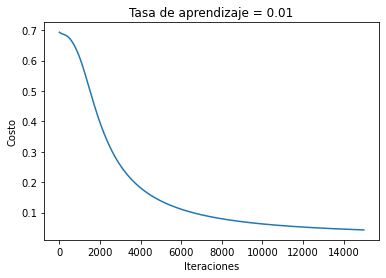

In [20]:
plt.plot(costs)
plt.ylabel('Costo')
plt.xlabel('Iteraciones')
plt.title("Tasa de aprendizaje = 0.01" )
plt.show()